In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 28

EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

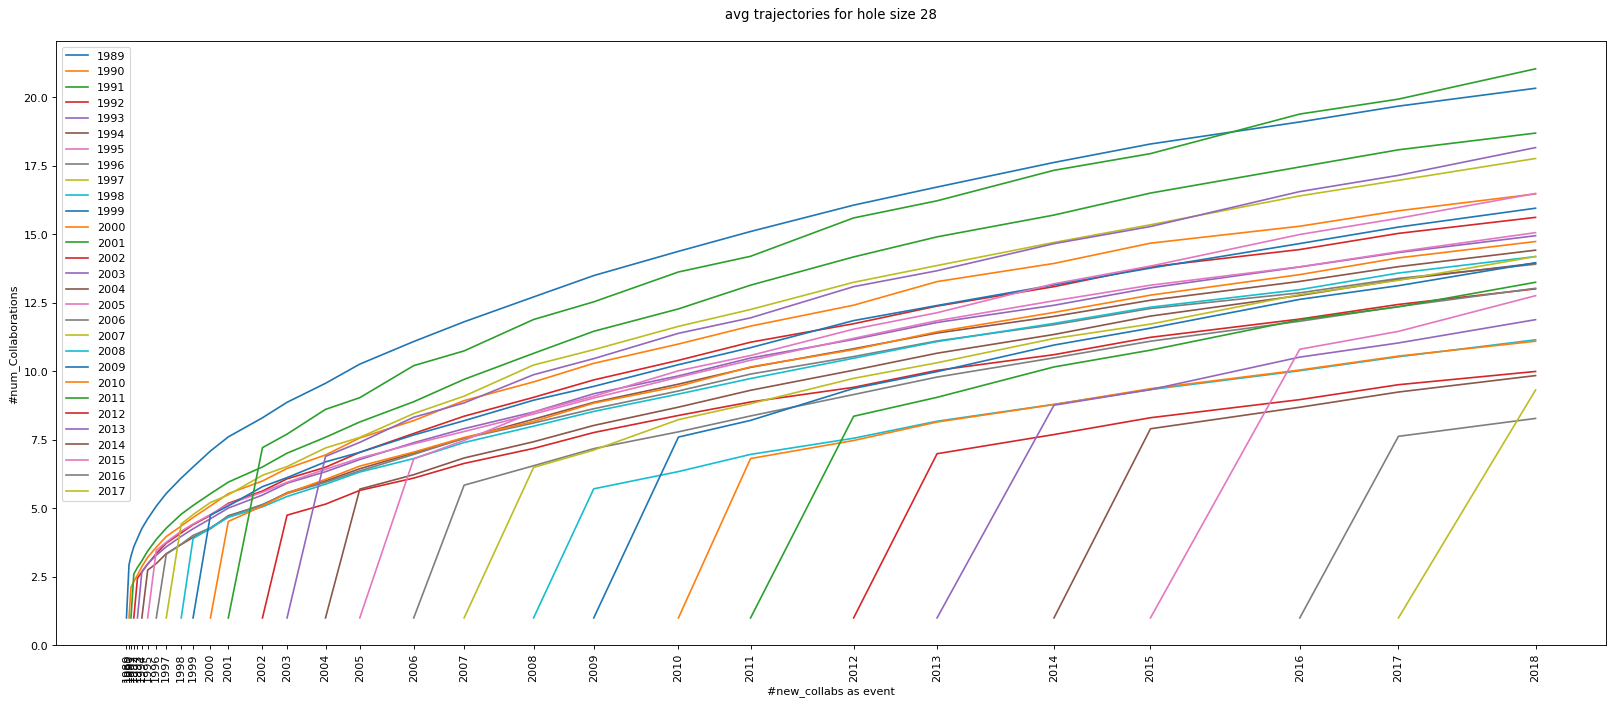

In [3]:
## Plot average trajectories 
plt.figure(figsize=(25, 10), dpi=80)
plt.title("avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(EVENTS, YEARS)
plt.show()

# **(2) Plotting fitting function**

<center><img src="./assets/1.jpg"></center>

In [4]:
# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[1: -3]
EVENTS_TO_CONSIDER = EVENTS[1: -3]

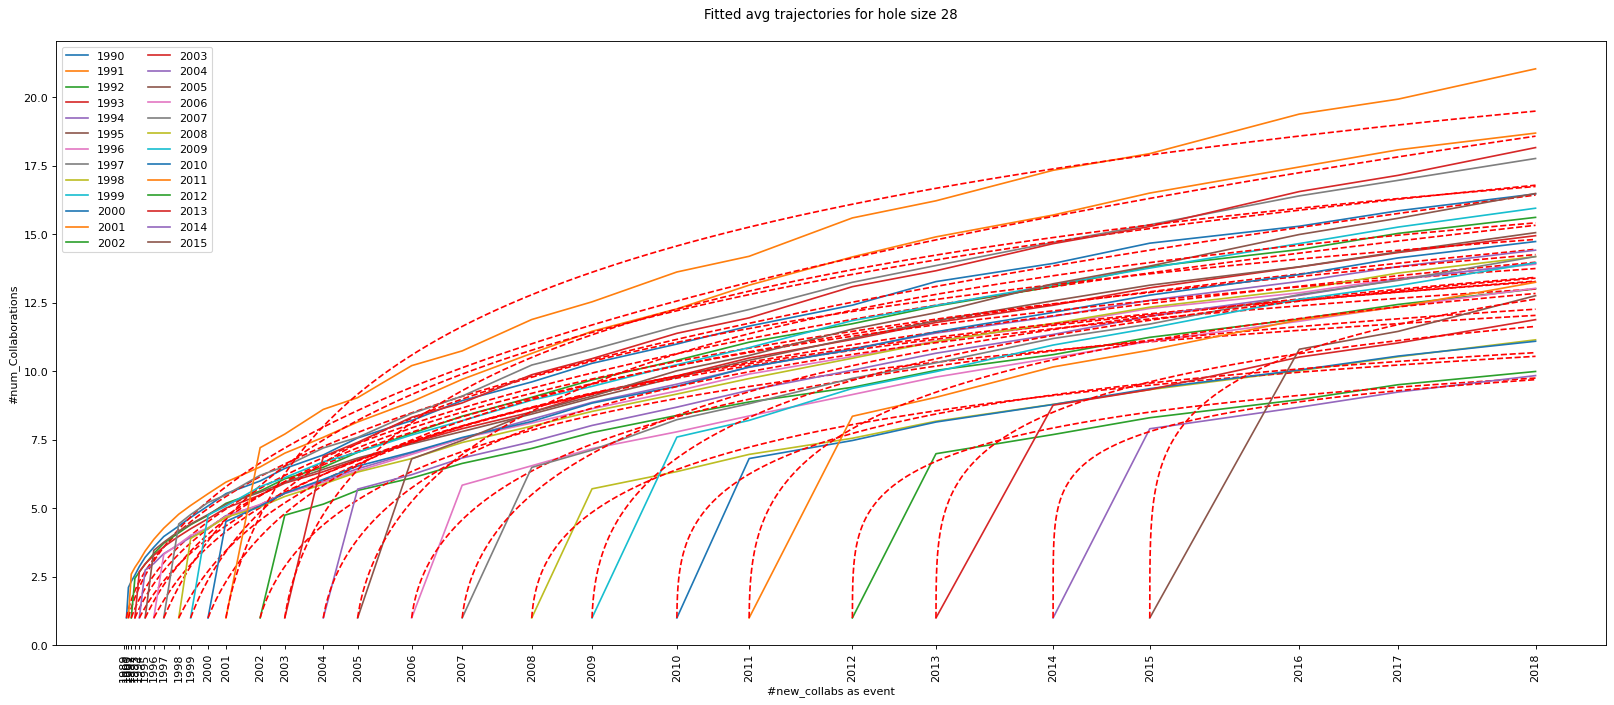

In [5]:
## Plot fitted average trajectories
plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []
for start_y in YEARS_TO_CONSIDER:
    
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size)     
    fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
    
    xdata = [a for a in range(x[0], x[-1])]
    fit_y = theoretical_func(xdata, alpha, beta, x[0])

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
    
    plt.plot(x,y, label=str(start_y))
    plt.plot(xdata, fit_y, 'r--')

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=2)
plt.xticks(EVENTS, YEARS)
plt.show()

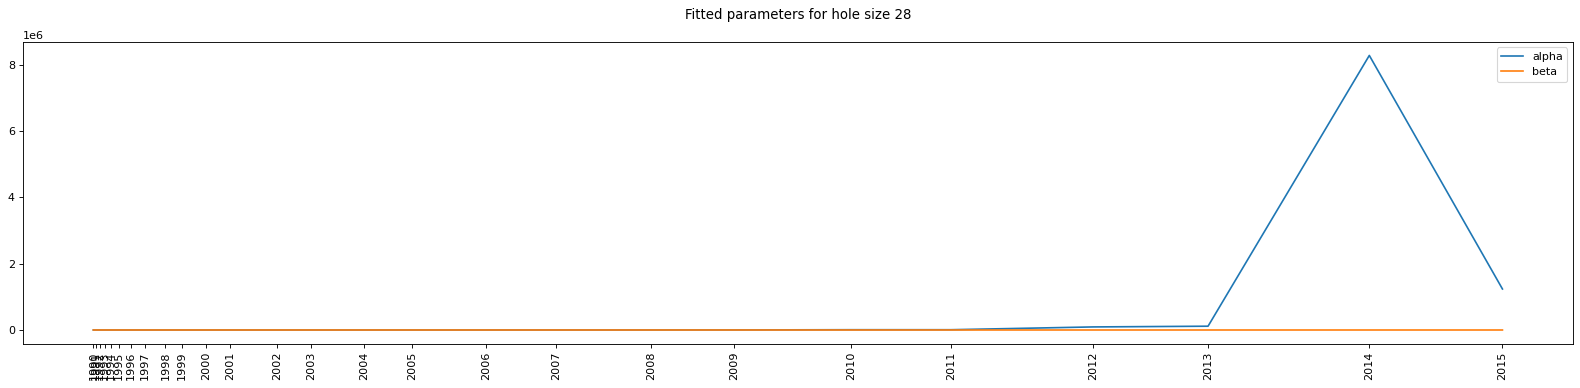

   start_y         alpha       beta
0     1990  2.995424e-02  16.165787
1     1991  1.068183e-01   6.106887
2     1992  1.986648e-01   3.817861
3     1993  3.543338e-01   2.669370
4     1994  4.714360e-01   2.312212
5     1995  1.015877e+00   1.600177
6     1996  1.578393e+00   1.321308
7     1997  2.886762e+00   1.163443
8     1998  4.259198e+00   0.958549
9     1999  7.855347e+00   0.837669
10    2000  1.029136e+01   0.770438
11    2001  3.182780e+01   0.669225
12    2002  3.161857e+01   0.576449
13    2003  7.329771e+01   0.555126
14    2004  9.070037e+01   0.494743
15    2005  1.209853e+02   0.507777
16    2006  1.965955e+02   0.436098
17    2007  2.455275e+02   0.442995
18    2008  6.145451e+02   0.354854
19    2009  1.299201e+03   0.357016
20    2010  8.395755e+03   0.264019
21    2011  8.169490e+03   0.289969
22    2012  9.232886e+04   0.206673
23    2013  1.141496e+05   0.222054
24    2014  8.273338e+06   0.150866
25    2015  1.235600e+06   0.196833


In [6]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.plot(EVENTS_TO_CONSIDER, alphas, label="alpha")
plt.plot(EVENTS_TO_CONSIDER, betas, label="beta")
plt.xticks(EVENTS_TO_CONSIDER, YEARS_TO_CONSIDER)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS_TO_CONSIDER[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors**

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

#### A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
#### B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

#### C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
#### D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [7]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

'''# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_B = minimize(err_f_B, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()'''


result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_D = minimize(err_f_D, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))

optimizing C function with 200 events -> params: [9.10367465e+04 1.99241658e-01], error: 31761.458870839688
optimizing D function with 200 events -> params: [7.55216851e+02 3.22651470e-01], error: 648.5606358224811



ValueError: Length of values (2) does not match length of index (4)

# **(4) Shift fitted trajectories, compute their average and fit it**

<center><img src="./assets/4.png" style="width: 1000px; height: 500px;"></center>

In [7]:
# Shift all fitted trajectories
shifted_funcs = []
since = 0

i = 0
for i in range(since, len(alphas)):
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER[i])

    xdata = [e+x[0] for e in ALL_EVENTS]        
    f = theoretical_func(xdata, alphas[i], betas[i], x[0])
    
    shifted_funcs.append(f) # add function to the set

In [8]:
# compute the average of the shifted functions
avg_shift = np.average(np.array(shifted_funcs), axis=0)

# fit the average curve
fit_avg_shift , alpha, beta = fit_trajectory(ALL_EVENTS, avg_shift) 

In [9]:
print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 1.2947522621581003e-06 
 beta*: 134470.39564185345


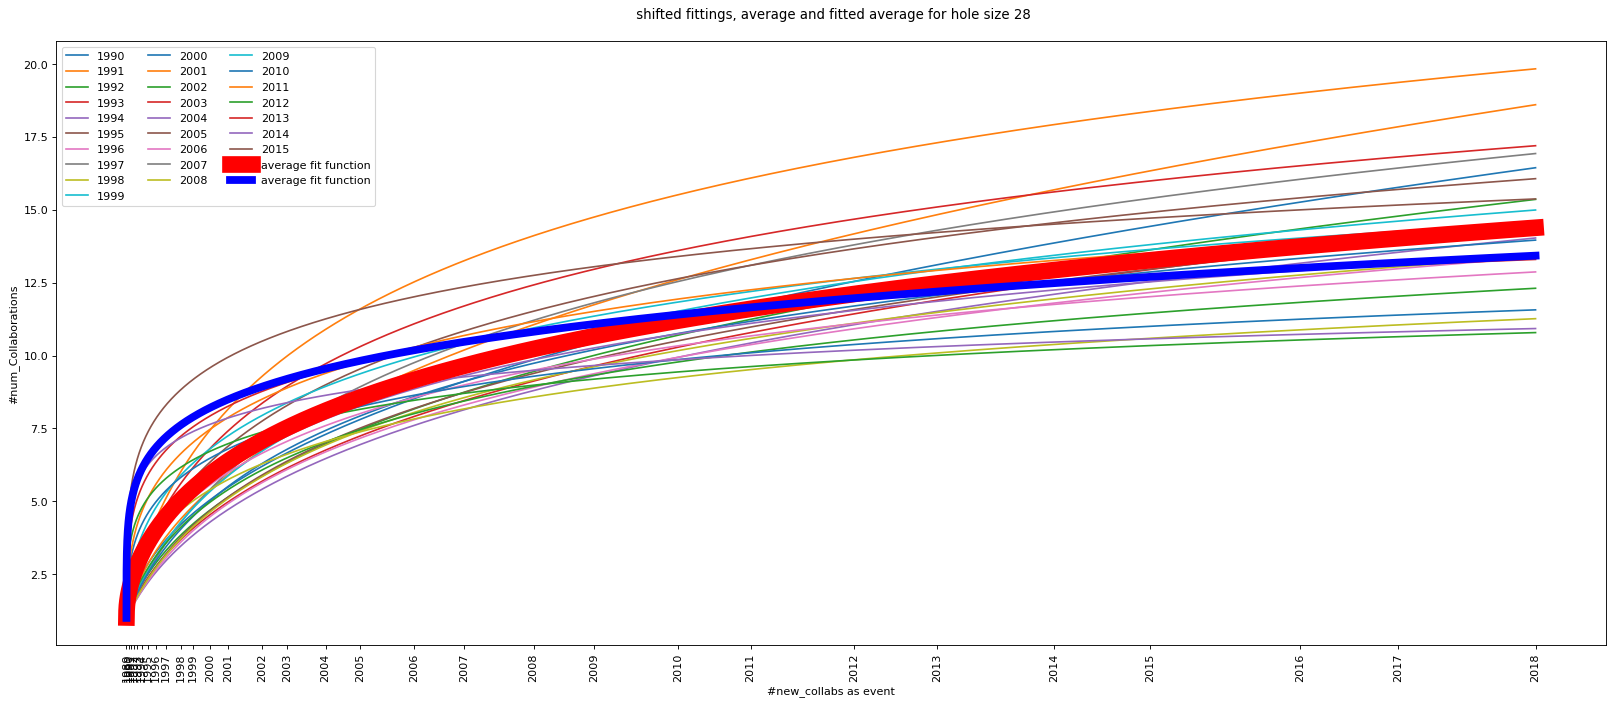

In [10]:
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

j = 0
for start_y in YEARS_TO_CONSIDER[since:]:
    plt.plot(ALL_EVENTS,shifted_funcs[j], label=start_y)
    j = j+1    
    
    
plt.plot(ALL_EVENTS, avg_shift, 'r-+', label="average fit function",  linewidth=15.0)
plt.plot(ALL_EVENTS, fit_avg_shift, 'b-', label="average fit function", linewidth=7.0)

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(EVENTS, YEARS)
plt.show()

# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

### Error fitted trajectories

In [ ]:
# Use the optimal alpha* and beta* to fit real trajectories for each error A,B,C,D
alphas_opt = [2.13429713e+04, 5.66549833e+04, 9.10367465e+04, 7.55216851e+02]
betas_opt = [2.10255928e-01, 2.04704156e-01, 1.99241658e-01, 3.22651470e-01]
print(alphas_opt, betas_opt)

In [ ]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    error_fit_functions[error_f_labels[i]] = functions_by_start_y

### Average fitted trajectories

In [ ]:
# Use the optimal alpha* and beta* to fit real trajectories for the fitted shifted average function
alpha, beta = 1.2947522621581003e-06, 134470.39564185345
print(alpha, beta)

In [11]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS_TO_CONSIDER:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    xdata = [e for e in range(x[0],x[-1])]
    
    general_fit_y = theoretical_func(xdata, alpha, beta, x[0])
    average_fit_functions.append(general_fit_y)

### plot everything

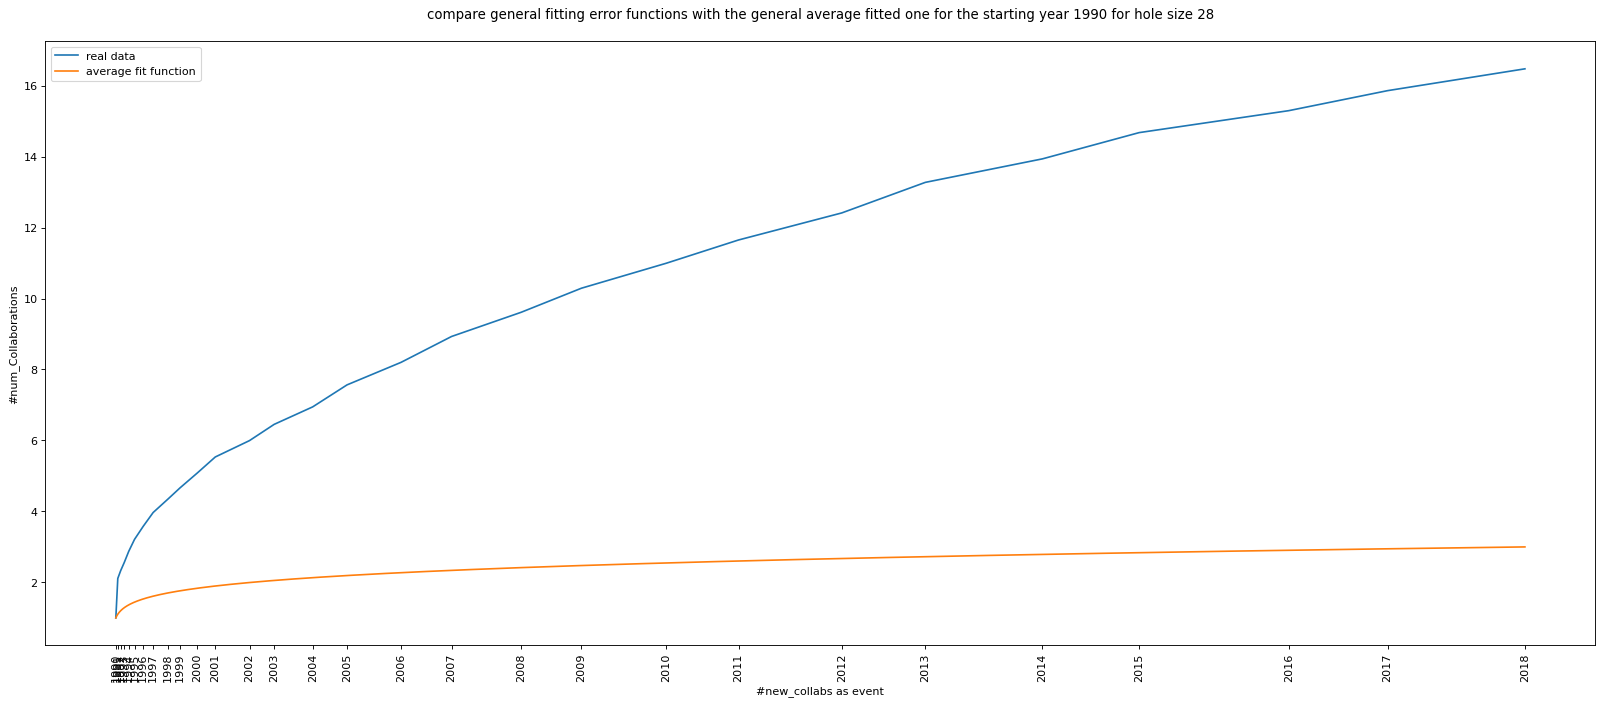

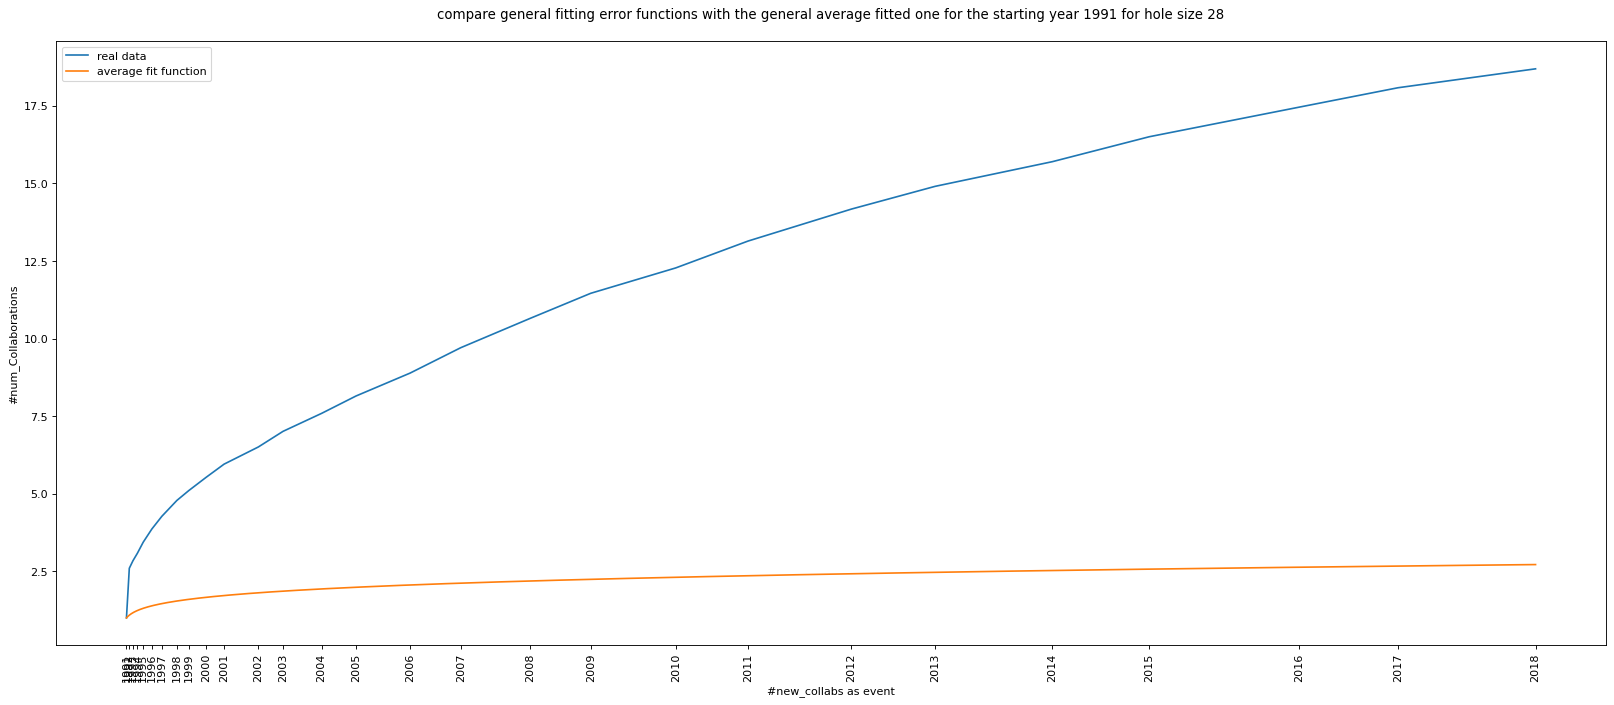

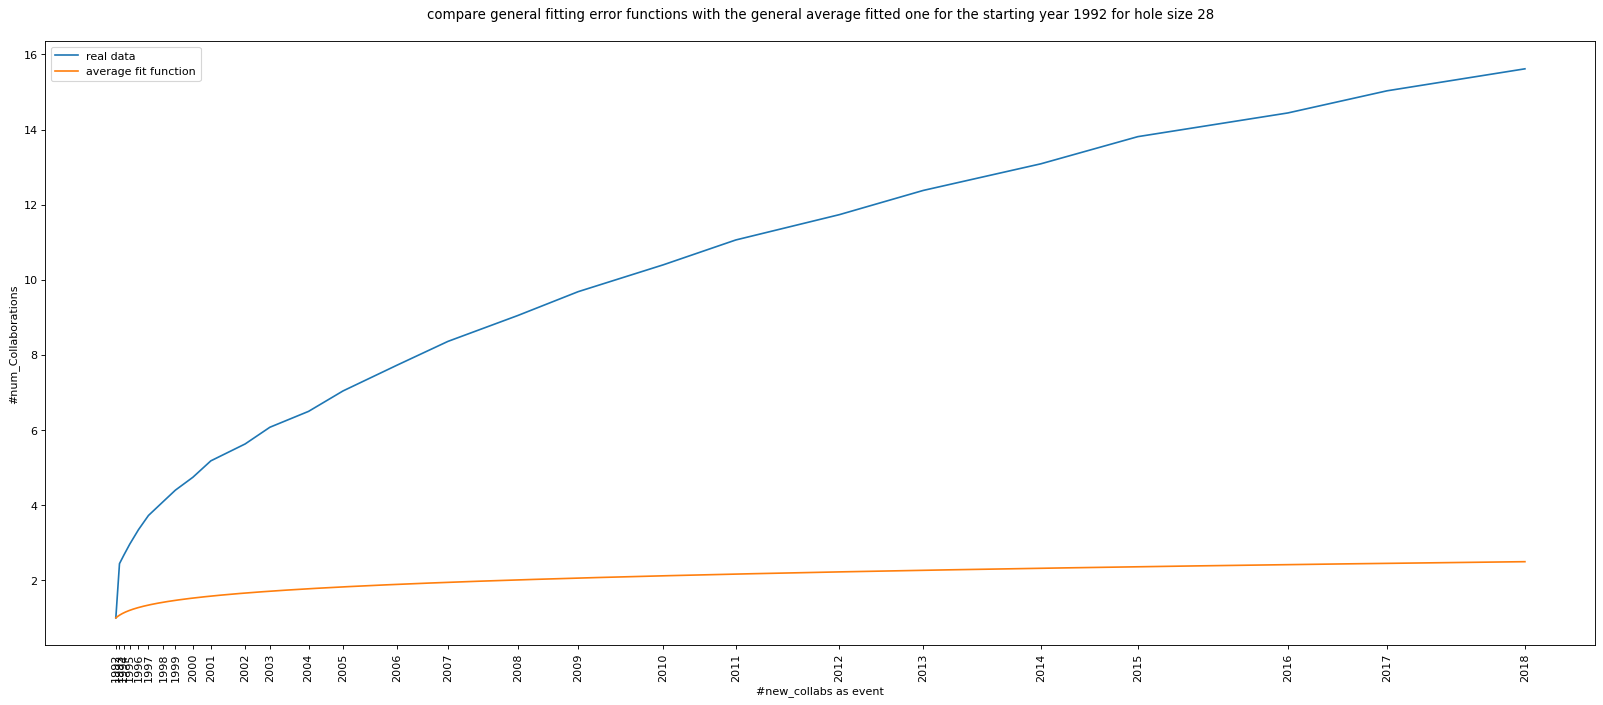

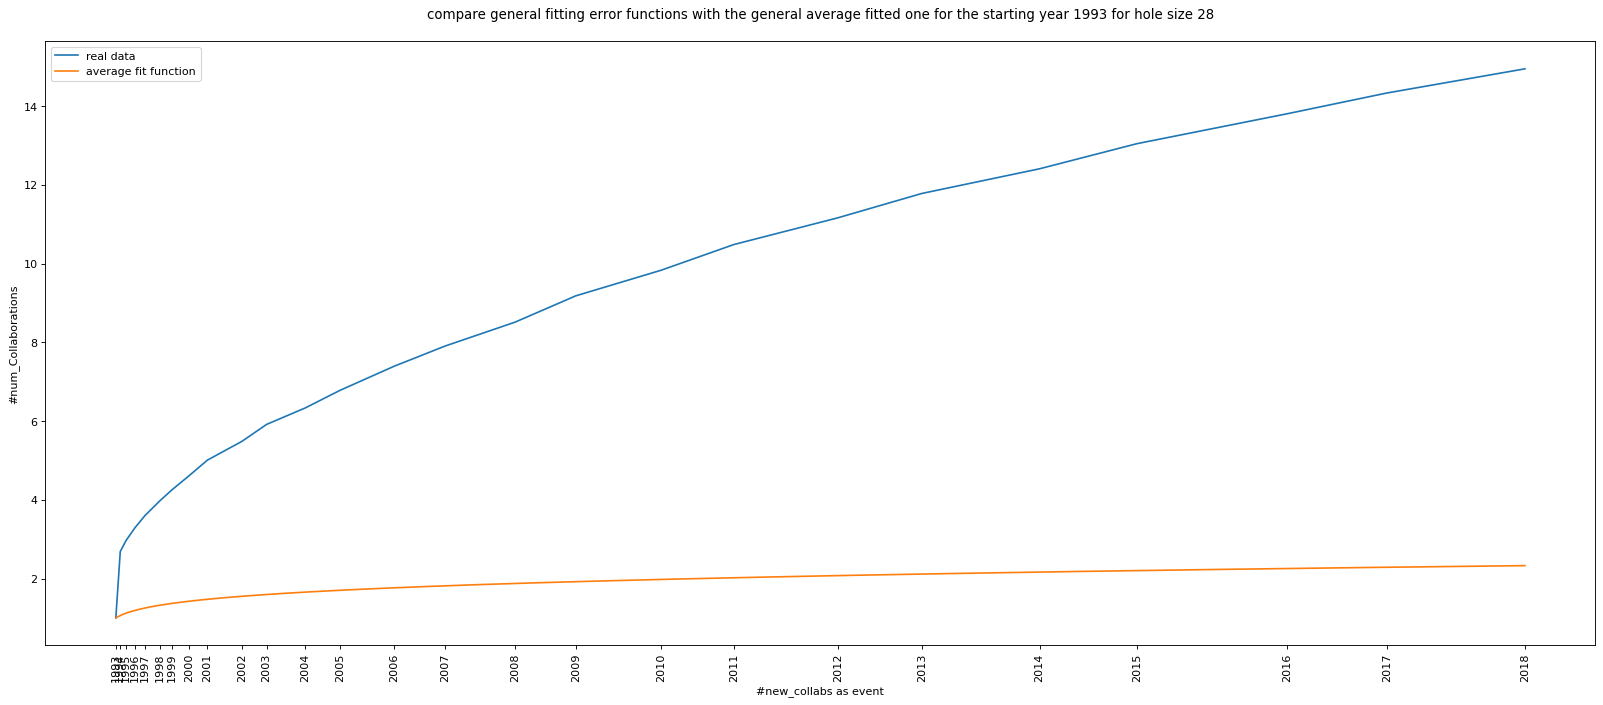

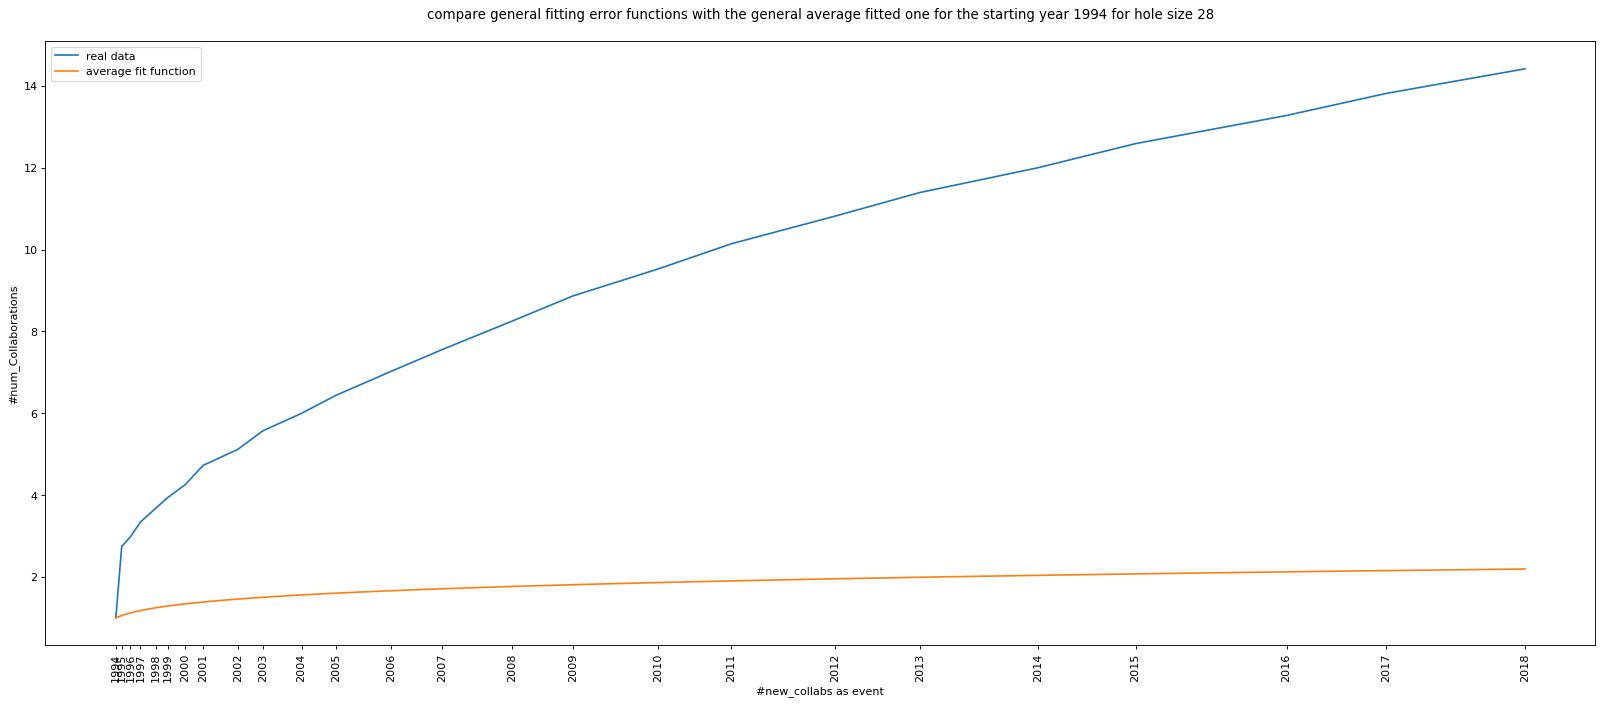

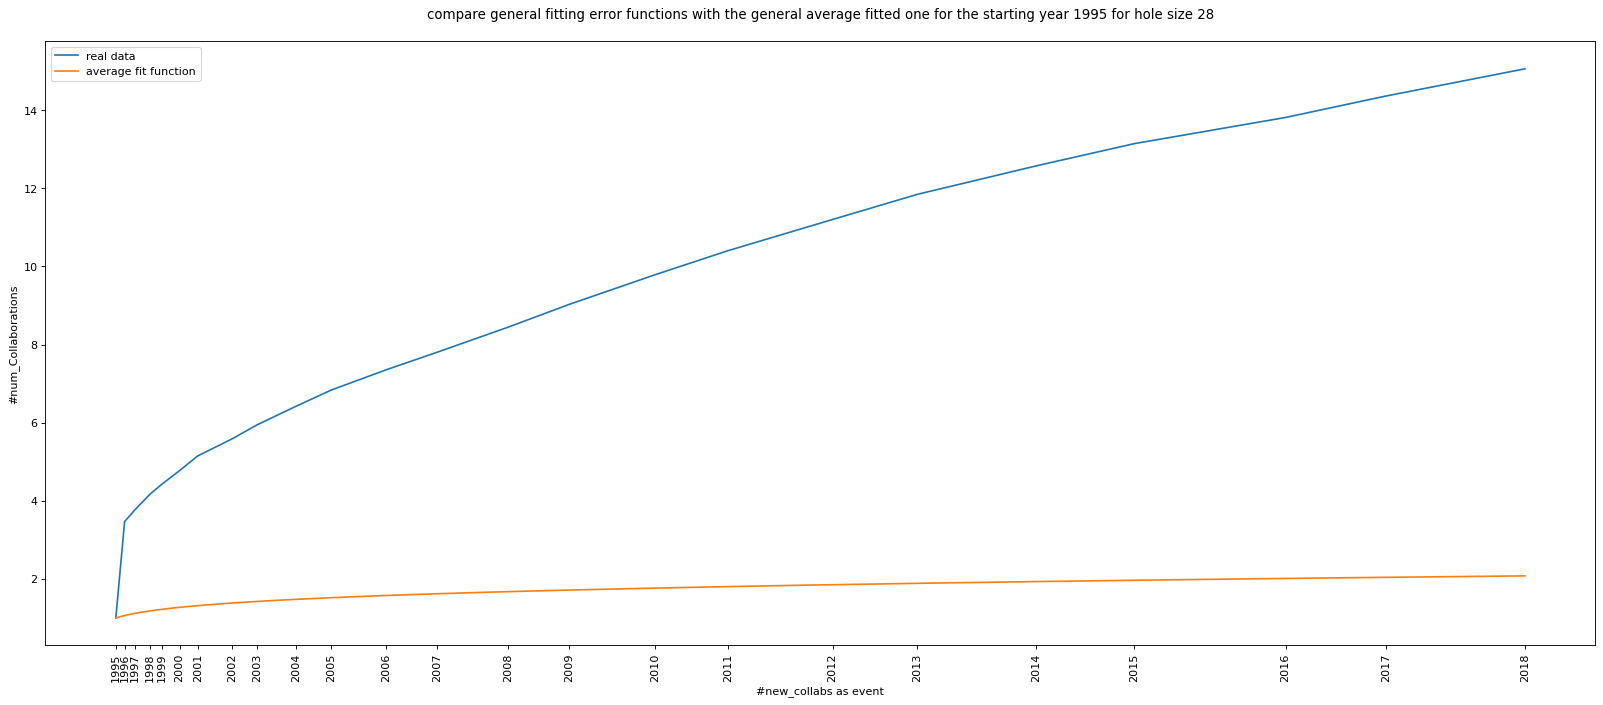

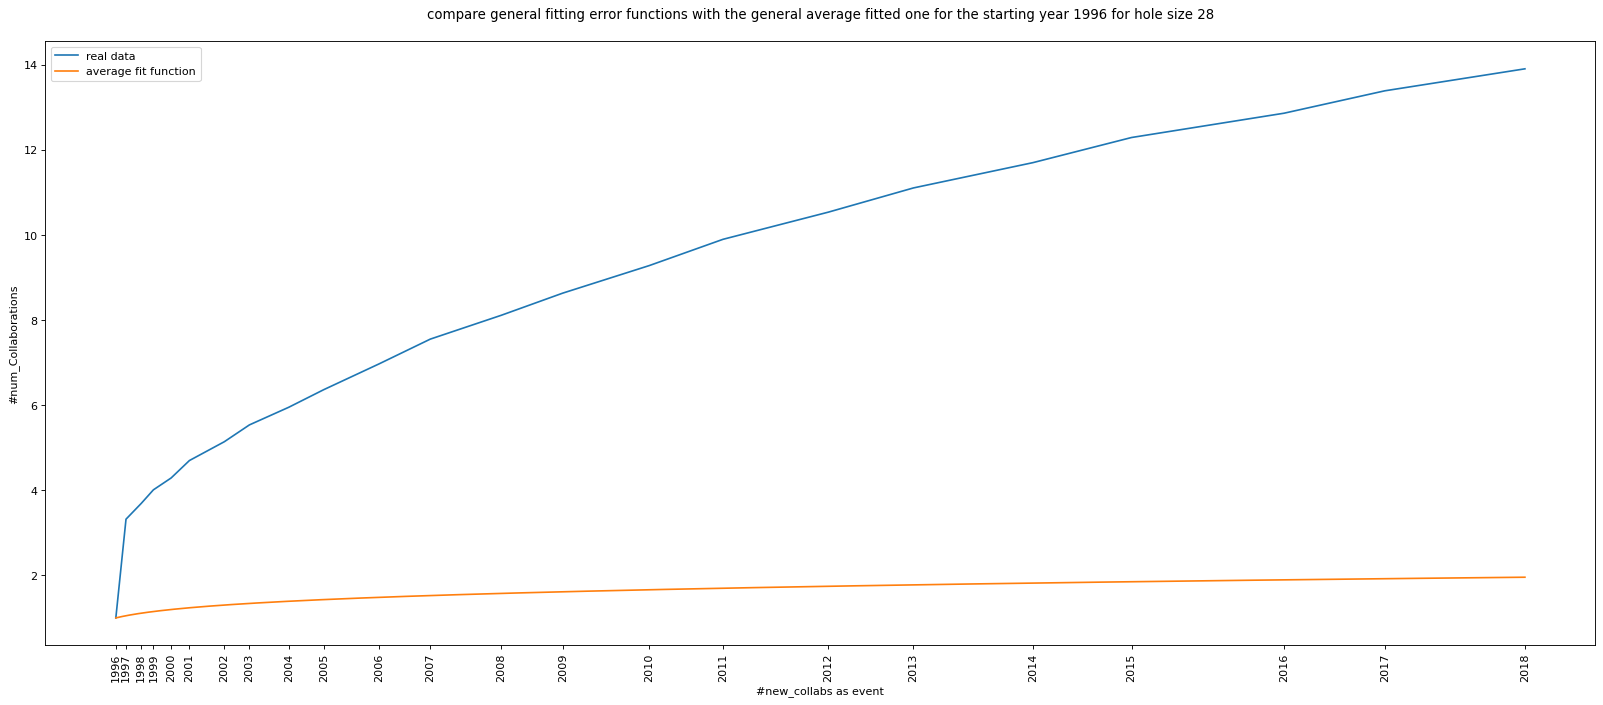

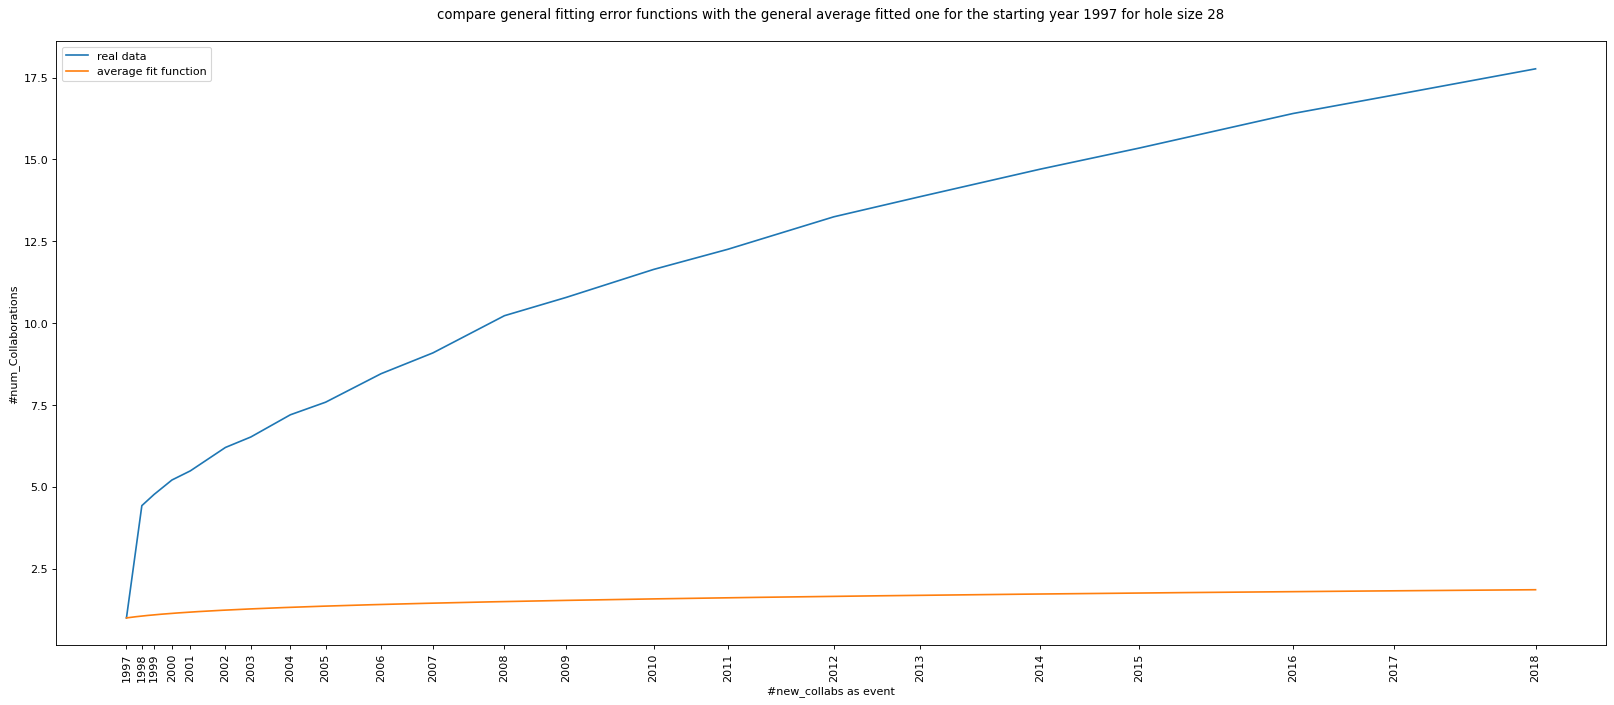

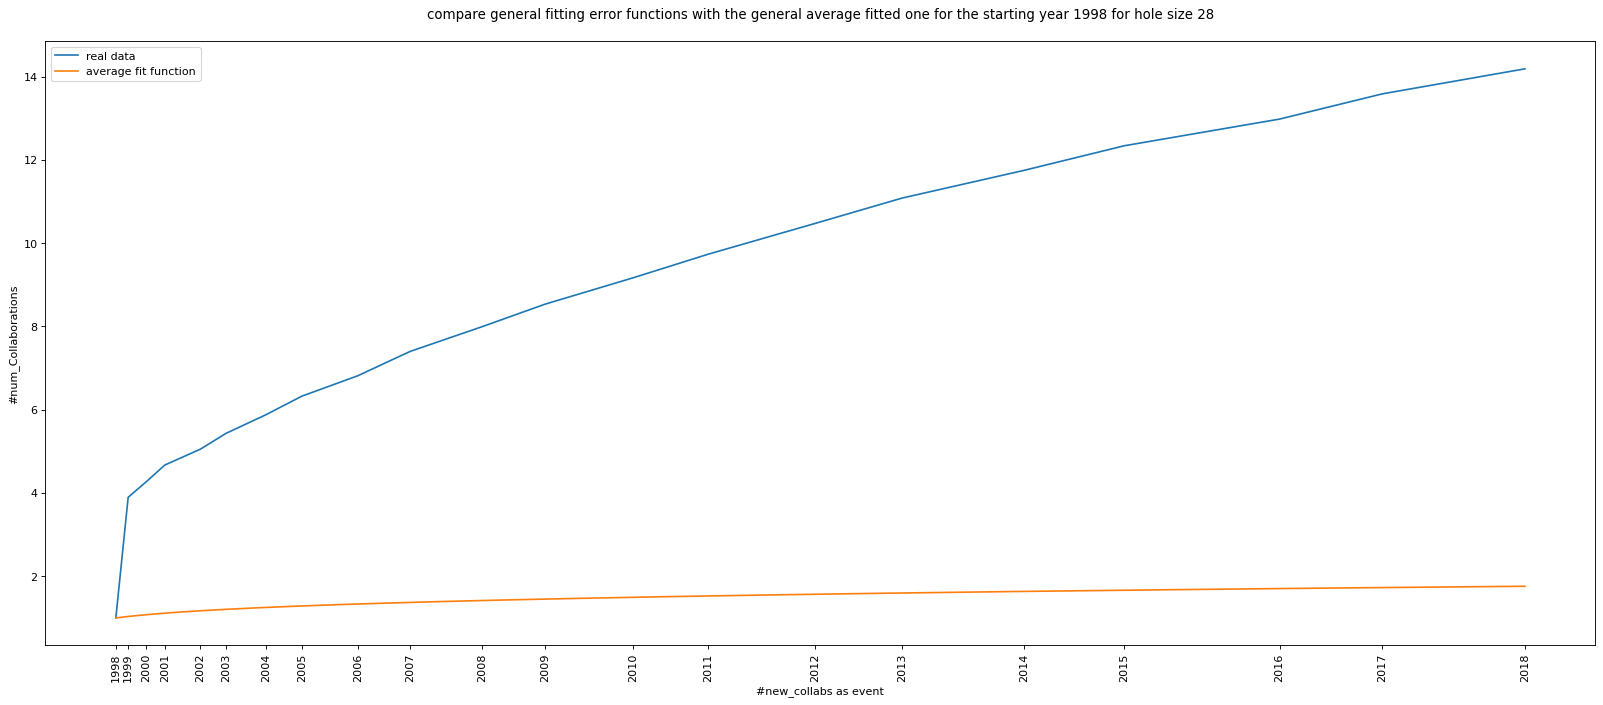

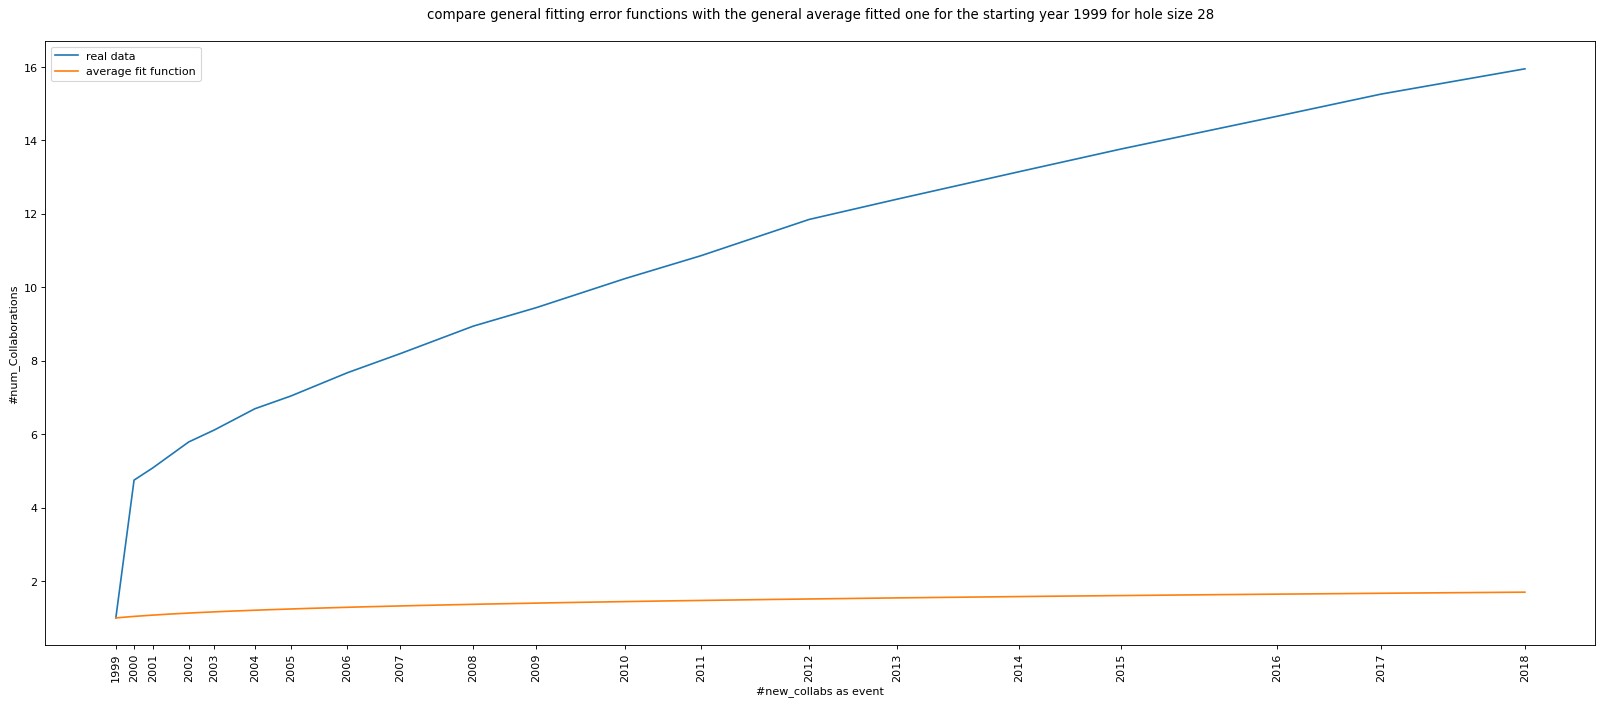

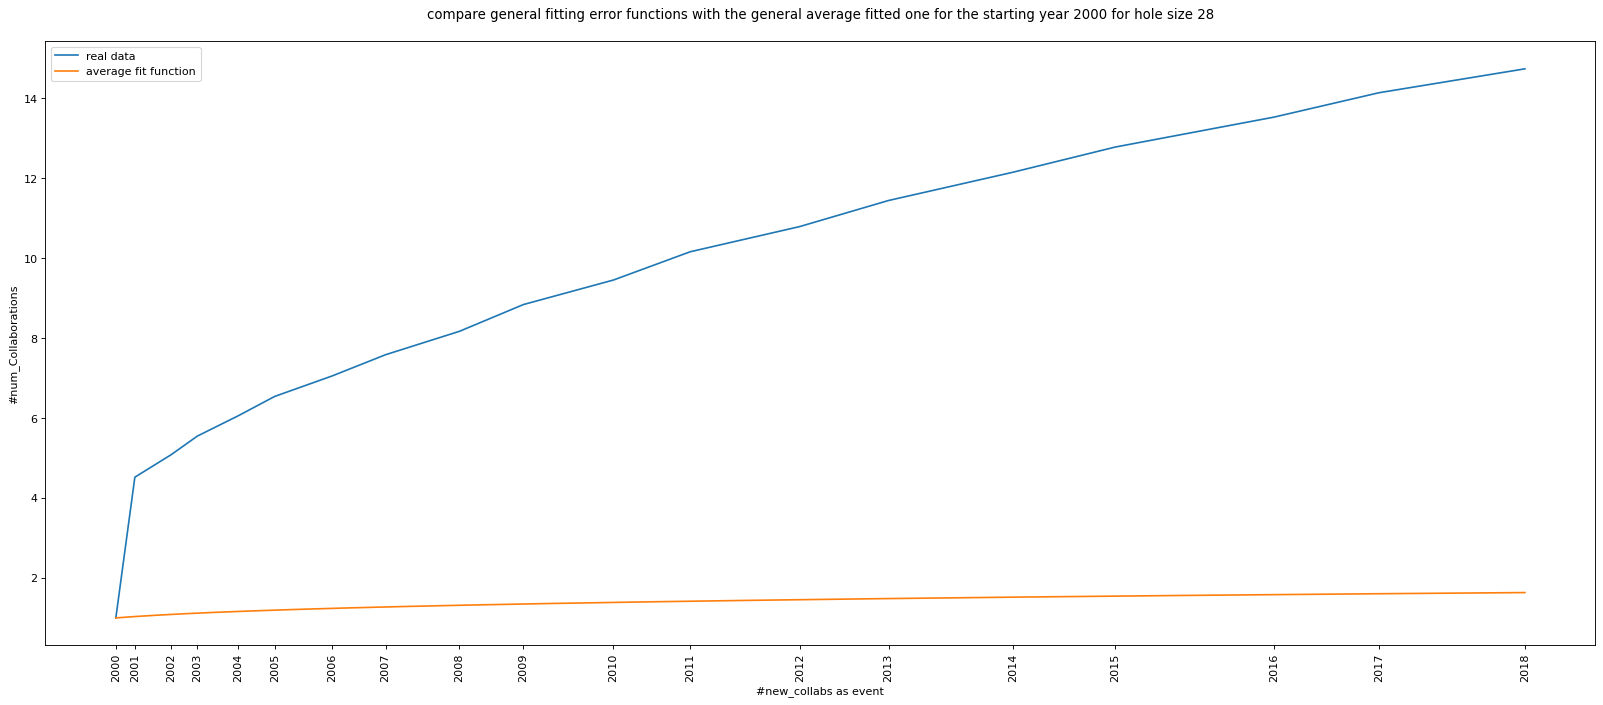

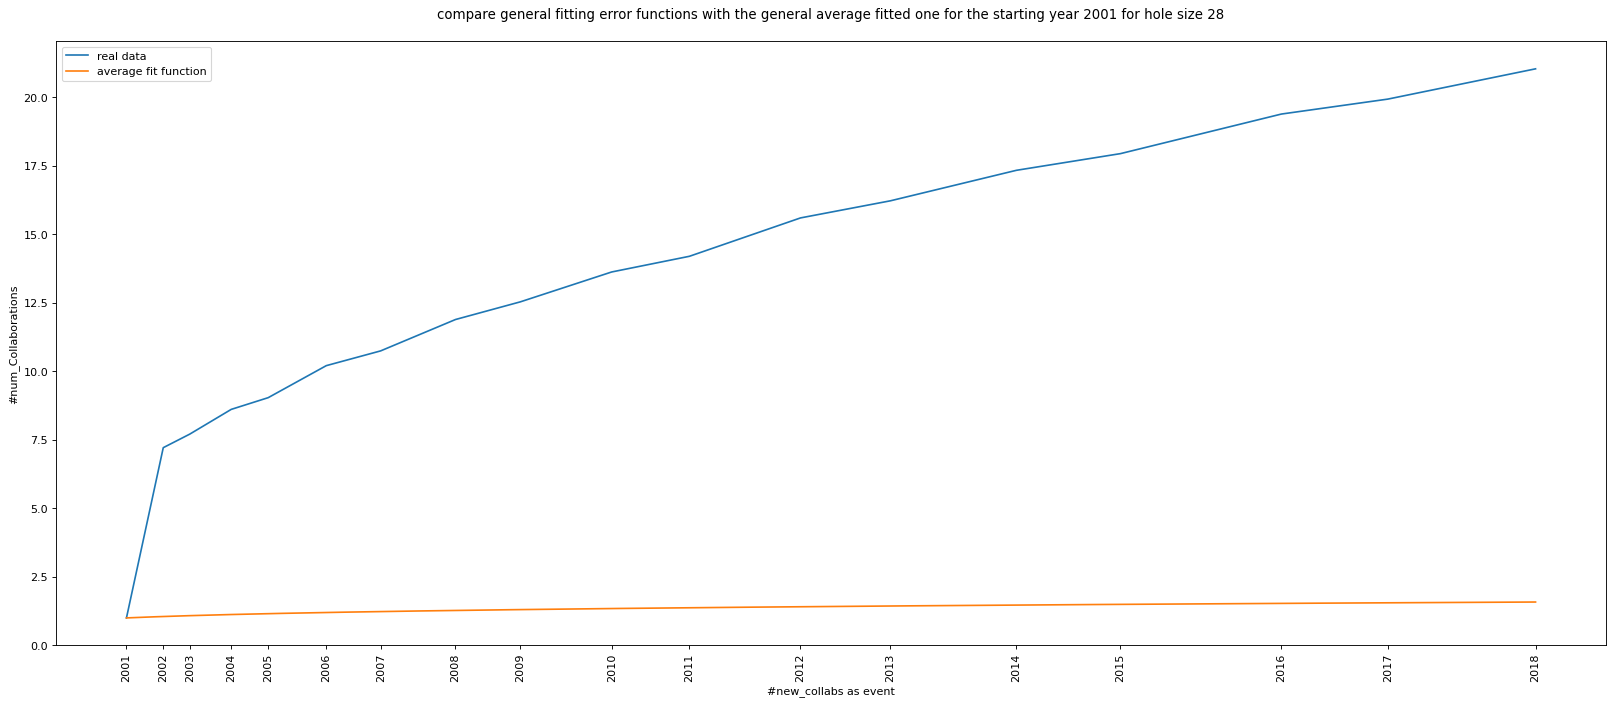

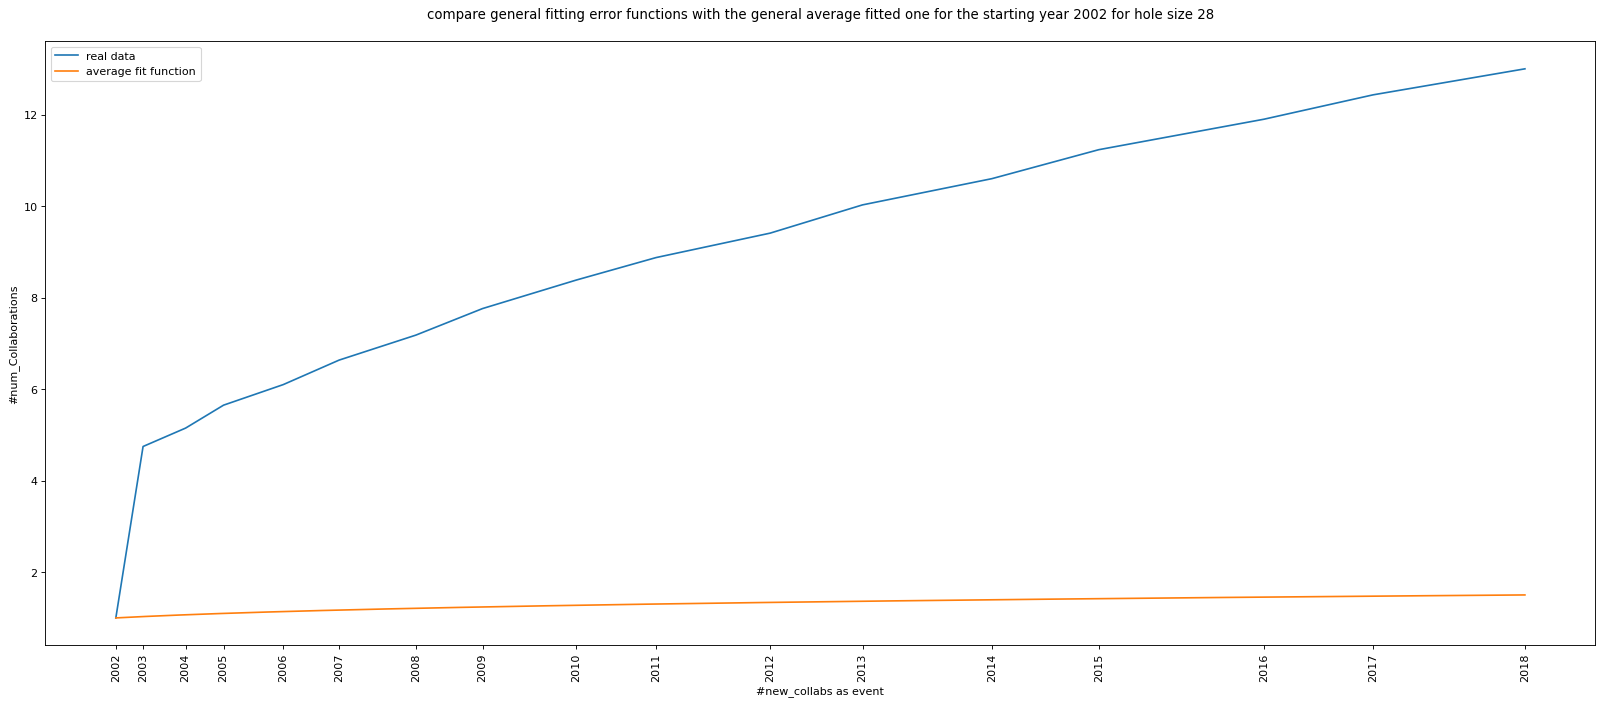

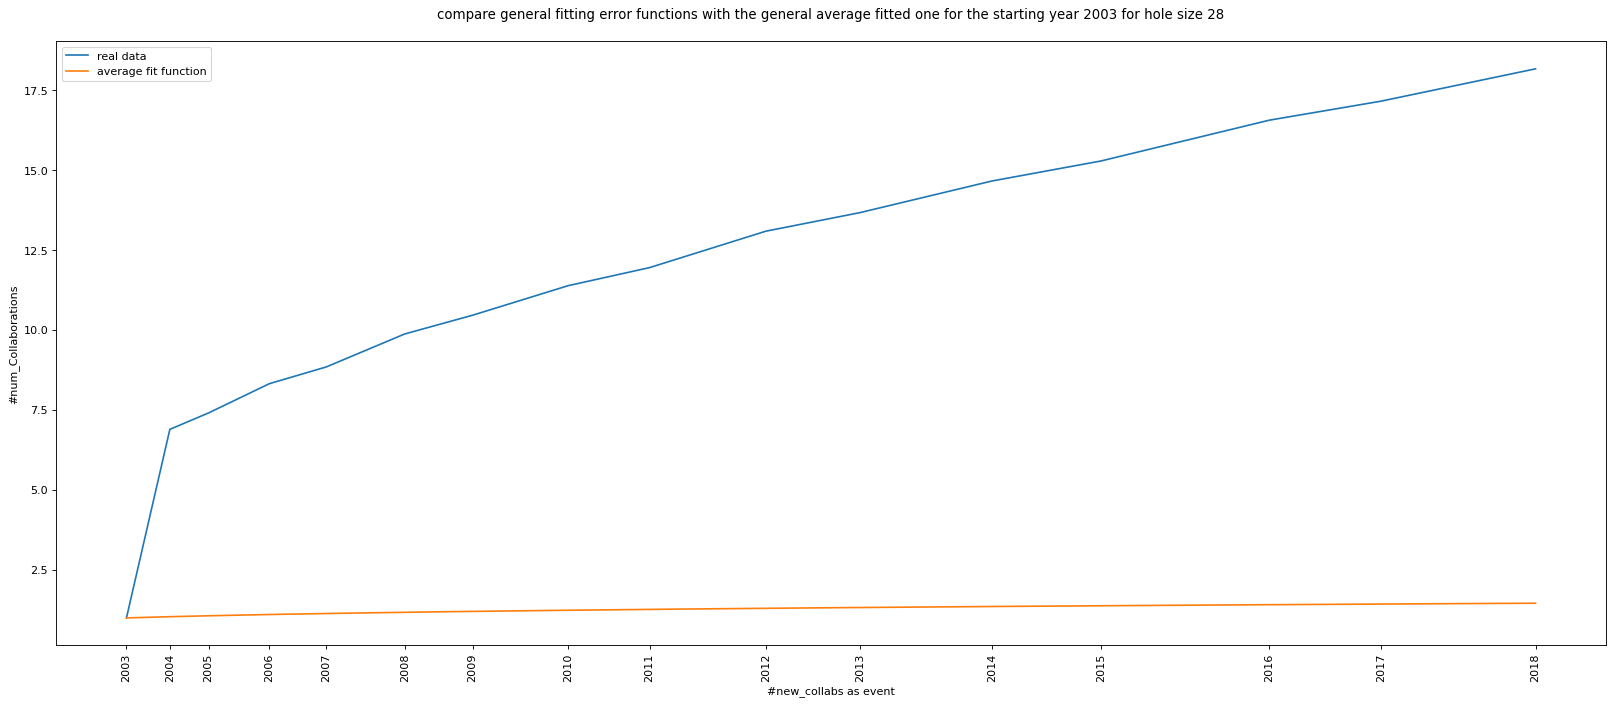

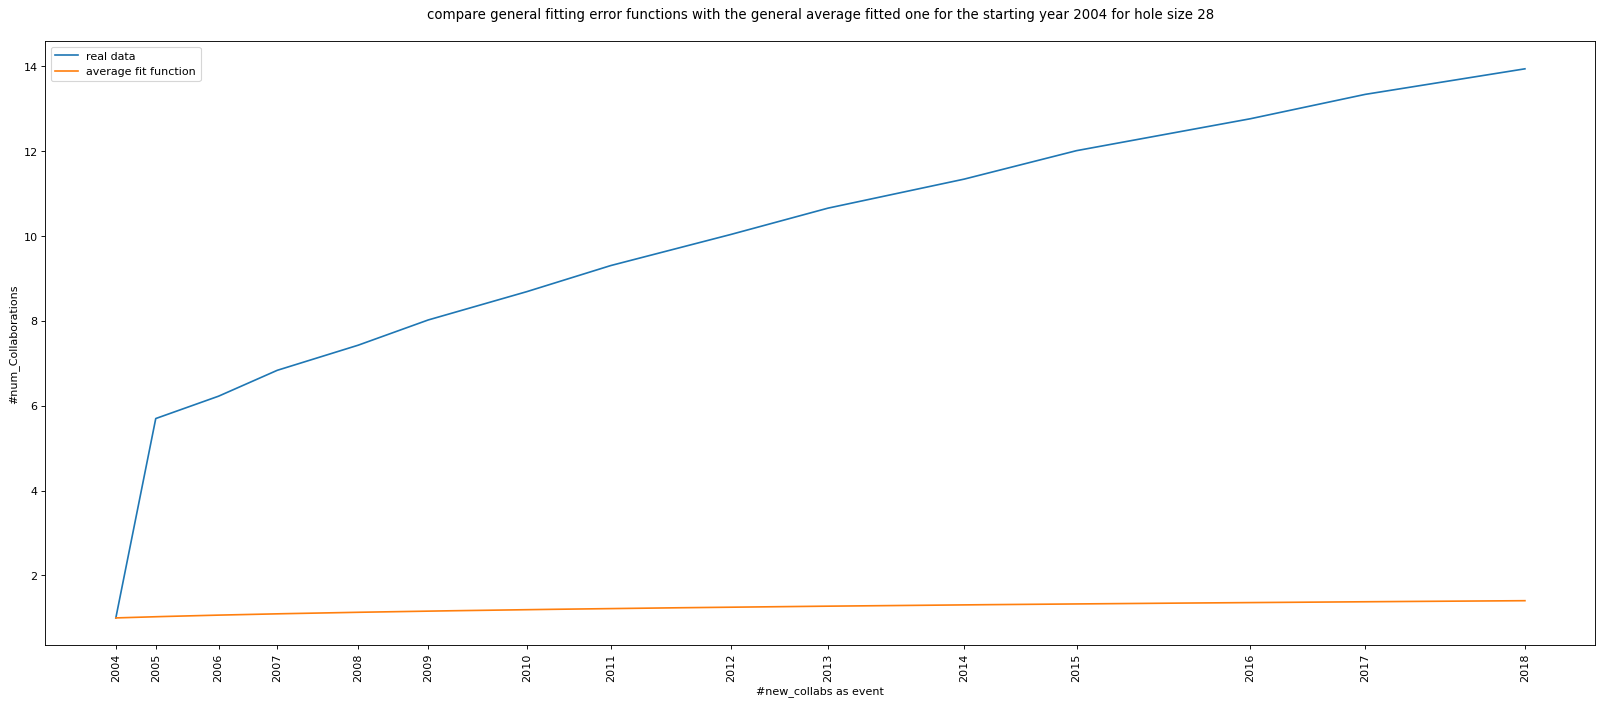

KeyboardInterrupt: 

In [12]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
for start_y in YEARS_TO_CONSIDER:
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    plt.plot(x,y, label="real data")
    
    xdata = [e for e in range(x[0],x[-1])]
    
    ''' 
    for i in range(len(error_f_labels)):
        err_f = error_fit_functions[error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ error_f_labels[i])
    '''

    plt.plot(xdata, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')    
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()
    
    time.sleep(15)